# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu. It is updated weekly and I last downloaded the dataset on 9/14/2020.  



## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q5"> 5. What significant does the family violence factor play, in violent crime, over time? 
><li><a href="#q6"> 6. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is update weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I originally attempted importing the data into this notebook using Sodapy's Socrata API method but found it cumbersome. Mainly, it didn't want to work with importing the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import folium
from folium import plugins

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 
              None)

plt.style.use('fivethirtyeight')

In [2]:
# Loading the data
df = pd.read_csv('crime_reports.csv')

In [3]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269339 entries, 0 to 2269338
Data columns (total 27 columns):
Incident Number                int64
Highest Offense Description    object
Highest Offense Code           int64
Family Violence                object
Occurred Date Time             object
Occurred Date                  object
Occurred Time                  float64
Report Date Time               object
Report Date                    object
Report Time                    float64
Location Type                  object
Address                        object
Zip Code                       float64
Council District               float64
APD Sector                     object
APD District                   object
PRA                            object
Census Tract                   float64
Clearance Status               object
Clearance Date                 object
UCR Category                   object
Category Description           object
X-coordinate                   float64
Y-coordin

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20857
Address                             12
Zip Code                         13848
Council District                 46923
APD Sector                        8808
APD District                      9277
PRA                              10508
Census Tract                   1424511
Clearance Status                602687
Clearance Date                  333475
UCR Category                   1497953
Category Description           1497953
X-coordinate                      9919
Y-coordinate                      9919
Latitude                         38288
Longitude                

## II. Data Scrubbing

There are several columns of data we won't be using in the analysis, mainly other date and geodata columns. So we'll drop those and also scrub some others. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The Clearance Status column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed the column to bool with Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am unsure how best to handle this so I am open to suggestions or advice.   

In [4]:
# Helper function for scrubbing the data
def clean_data(df):
    drop_col = ['Occurred Time', 
                'Occurred Date', 
                'Report Date', 
                'Report Time', 
                'Census Tract', 
                'UCR Category', 
                'Category Description', 
                'X-coordinate', 
                'Y-coordinate', 
                'Location']
    df.drop(drop_col, 
            axis=1, 
            inplace=True)
    clean_col = ['Zip Code', 
                 'Report Date Time', 
                 'Occurred Date Time'] 
    df.dropna(subset=clean_col, 
              inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    """Convert the following to bools"""
    d = {'Y': True, 
         'N': False}
    e = {'C': True, 
         'O': True, 
         'N': False}
    df.clearance_status = df.clearance_status.map(e)
    df.clearance_status = df.clearance_status.astype('bool')
    df.family_violence = df.family_violence.map(d)
    df.family_violence = df.family_violence.astype('bool') 
    """Convert the following to datetime type"""
    date_col = ['occurred_date_time', 
                'clearance_date', 
                'report_date_time'] 
    """Convert the following to category type"""
    cat_col = ['highest_offense_description', 
               'location_type', 
               'apd_sector'] 
    df[date_col] = df[date_col].astype('datetime64') 
    df[cat_col] = df[cat_col].astype('category') 
    """Convert the following to integer type"""
    int_col = ['zip_code']
    df['year'] = pd.to_datetime(df['occurred_date_time'], 
                                format='%m/%d/%Y').dt.year 
    df['month'] = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.month 
    df['hour'] = pd.to_datetime(df['occurred_date_time'], 
                                format='%m/%d/%Y').dt.hour
    df[int_col] = df[int_col].astype('int64')
    """Set the index"""
    df.set_index(['occurred_date_time'], 
                 inplace=True)
    df.sort_index(inplace=True)
    return df
df = clean_data(df)

In [5]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                     0
highest_offense_description         0
highest_offense_code                0
family_violence                     0
report_date_time                    0
location_type                   20391
address                             0
zip_code                            0
council_district                33075
apd_sector                          8
apd_district                       11
pra                                11
clearance_status                    0
clearance_date                 330235
latitude                        27621
longitude                       27621
year                                0
month                               0
hour                                0
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
family_violence                          bool
report_date_time               datetime64[ns]
location_type                        category
address                                object
zip_code                                int64
council_district                      float64
apd_sector                           category
apd_district                           object
pra                                    object
clearance_status                         bool
clearance_date                 datetime64[ns]
latitude                              float64
longitude                             float64
year                                    int64
month                                   int64
hour                                    int64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,
2003-01-01,2005901307,SEXUAL ASSAULT OF CHILD/OBJECT,1707,False,2005-03-31 16:40:00,RESIDENCE / HOME,6600 BLOCK ED BLUESTEIN BLVD,78723,NaN,ED,3,299,True,2005-07-12,NaN,NaN,2003,1,0
2003-01-01,20035015514,IDENTITY THEFT,4022,False,2003-10-06 10:52:00,RESIDENCE / HOME,5708 WHITEBROOK DR,78724,1.0,CH,7,300,True,2003-10-31,30.305744,-97.655117,2003,1,0
2003-01-01,20085024074,IDENTITY THEFT,4022,False,2008-05-10 18:36:00,RESIDENCE / HOME,7312 WHISPERING OAKS DR,78745,5.0,FR,1,525,True,2008-05-13,30.202175,-97.817542,2003,1,0
2003-01-01,20135010506,IDENTITY THEFT,4022,False,2013-03-11 17:28:00,RESIDENCE / HOME,7001 S CONGRESS AVE,78745,2.0,FR,3,528,False,2013-03-12,30.188878,-97.780075,2003,1,0
2003-01-01,20095041149,IDENTITY THEFT,4022,False,2009-07-22 11:09:00,RESIDENCE / HOME,1941 GASTON PLACE DR,78723,1.0,ID,4,295,False,2009-07-28,30.312126,-97.688964,2003,1,0


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,
2020-09-19 16:29:00,20205037514,THEFT,600,False,2020-09-19 19:09:00,GROCERY / SUPERMARKET,1030 NORWOOD PARK BLVD,78753,4.0,ID,2,252,True,NaT,30.339153,-97.691169,2020,9,16
2020-09-19 19:18:00,20205037522,ASSAULT BY CONTACT,902,False,2020-09-19 20:20:00,STREETS / HWY / ROAD / ALLEY,S IH 35 SVRD SB / E STASSNEY LN,78745,3.0,DA,3,515,True,NaT,30.198687,-97.764494,2020,9,19
2020-09-19 19:31:00,20205037517,BURGLARY OF VEHICLE,601,False,2020-09-19 19:31:00,PARKING LOTS / GARAGE,605 DAVIS ST,78701,9.0,GE,3,408,True,NaT,30.260101,-97.739215,2020,9,19
2020-09-19 19:49:00,20205037519,IDENTITY THEFT,4022,False,2020-09-19 19:49:00,RESIDENCE / HOME,3130 BARNSLEY DR,78745,5.0,FR,1,98,True,NaT,30.204538,-97.827831,2020,9,19
2020-09-19 19:53:00,20205037521,THEFT BY SHOPLIFTING,607,False,2020-09-19 20:16:00,OTHER / UNKNOWN,1801 E 51ST ST,78723,9.0,BA,4,900,True,NaT,30.301784,-97.698671,2020,9,19


## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

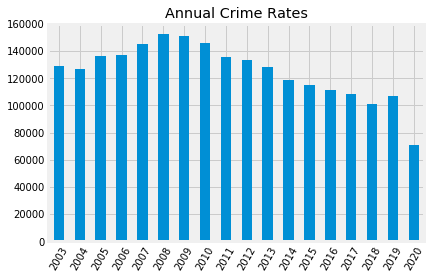

In [6]:
# Creating and visualizing a data frame for the overall yearly crime rate since 2003
crimes_per_year = df['year'].value_counts().sort_index() 

crimes_per_year.plot.bar(rot=60, 
                         title='Annual Crime Rates')
plt.show()

# Creating a dataframe for monthly crime rates (2003-Now)
crimes_per_month = df['month'].value_counts().sort_index()

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

***Note: I am only including zipcodes and crimes, for questions 1 - 3, that >= 1%. Any zipcodes or crime percentages, below 1%, will be discluded to simplify analysis and visualizations.***

Question 4 regards violent crime. For violent crime, I chose to examine 4 categories: aggrivated assault, rape, murder, and capital murder. I realize there are other types of violent crime, but for now I am sticking with these 4 categories. 

78741    204212
78753    176174
78701    166843
78758    156621
78704    152626
78745    148777
78702    135498
78744    124601
78723    116747
78752     83465
78748     67001
78759     65185
78751     63220
78757     56923
78705     56207
78721     47134
78749     39881
78724     37153
78727     35312
78703     34739
78731     28154
78746     27839
78729     25213
78750     23232
78754     22293
78722     19506
78756     17918
78617     16926
78735     15442
78747     12951
          ...  
78730      3021
78653      1847
78728      1381
78652       683
78664       369
78712       334
78733       319
78732       300
78737       214
78681       210
78610       130
78734       102
78641        66
0            62
78738        43
78621        28
78645        24
78620        17
76574        17
78640        16
78713        12
78612        11
78669         9
78634         5
78615         4
78626         3
78642         2
78619         1
78654         1
78628         1
Name: zip_code, Length: 

----------------------------------


78741    9.054603e-02
78753    7.811420e-02
78701    7.397691e-02
78758    6.944455e-02
78704    6.767320e-02
78745    6.596658e-02
78702    6.007877e-02
78744    5.524713e-02
78723    5.176472e-02
78752    3.700774e-02
78748    2.970773e-02
78759    2.890253e-02
78751    2.803126e-02
78757    2.523922e-02
78705    2.492175e-02
78721    2.089885e-02
78749    1.768293e-02
78724    1.647336e-02
78727    1.565707e-02
78703    1.540301e-02
78731    1.248327e-02
78746    1.234360e-02
78729    1.117925e-02
78750    1.030089e-02
78754    9.884545e-03
78722    8.648811e-03
78756    7.944704e-03
78617    7.504858e-03
78735    6.846864e-03
78747    5.742374e-03
             ...     
78730    1.339488e-03
78653    8.189456e-04
78728    6.123248e-04
78652    3.028370e-04
78664    1.636118e-04
78712    1.480930e-04
78733    1.414422e-04
78732    1.330177e-04
78737    9.488596e-05
78681    9.311239e-05
78610    5.764100e-05
78734    4.522602e-05
78641    2.926389e-05
0        2.749032e-05
78738    1

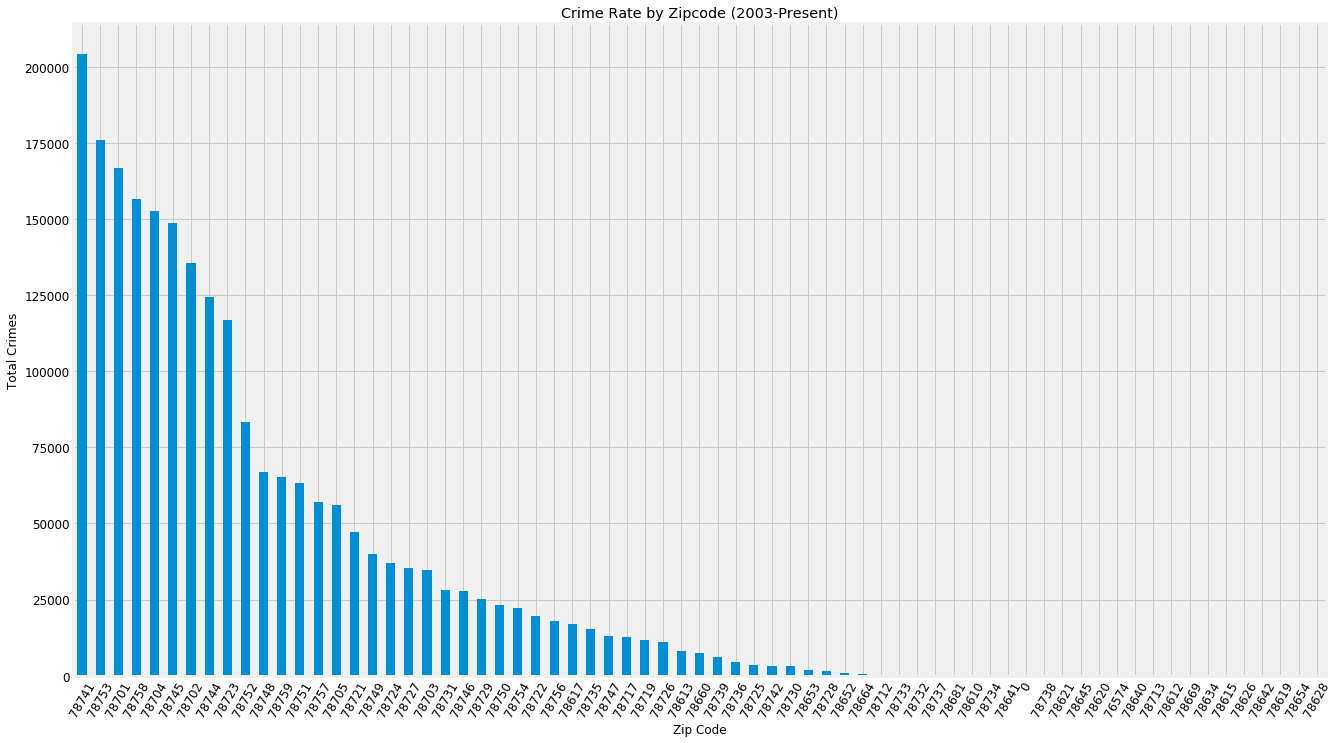

In [8]:
figsize = [20,12]

# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts()
display(zip_codes)
print('----------------------------------')
display(df.zip_code.value_counts(normalize=True))


df.zip_code.value_counts().plot.bar(fontsize=12, 
                                    figsize=figsize,   
                                    rot=60)

plt.xlabel('Zip Code')
plt.ylabel('Total Crimes')
plt.title('Crime Rate by Zipcode (2003-Present)')
plt.show()

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.06%. This is a significant 1.3 percentage points higher than the number 2 area 78753 which hosts 7.8% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             16949
BURGLARY OF VEHICLE               15802
FAMILY DISTURBANCE                14351
CRIMINAL MISCHIEF                  9264
THEFT BY SHOPLIFTING               7527
ASSAULT W/INJURY-FAM/DATE VIOL     7042
BURGLARY OF RESIDENCE              6016
DWI                                4894
DISTURBANCE - OTHER                4687
CUSTODY ARREST TRAFFIC WARR        4333
HARASSMENT                         4169
AUTO THEFT                         4074
POSS OF DRUG PARAPHERNALIA         3709
PUBLIC INTOXICATION                3346
ASSAULT WITH INJURY                3246
CRIMINAL TRESPASS                  3102
POSS CONTROLLED SUB/NARCOTIC       2939
RUNAWAY CHILD                      2894
WARRANT ARREST NON TRAFFIC         2786
POSSESSION OF MARIJUANA            2684
BURGLARY NON RESIDENCE             2450
VIOL CITY ORDINANCE - OTHER        1861
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096206
BURGLARY OF VEHICLE               0.089695
FAMILY DISTURBANCE                0.081459
CRIMINAL MISCHIEF                 0.052584
THEFT BY SHOPLIFTING              0.042725
ASSAULT W/INJURY-FAM/DATE VIOL    0.039972
BURGLARY OF RESIDENCE             0.034148
DWI                               0.027779
DISTURBANCE - OTHER               0.026604
CUSTODY ARREST TRAFFIC WARR       0.024595
HARASSMENT                        0.023664
AUTO THEFT                        0.023125
POSS OF DRUG PARAPHERNALIA        0.021053
PUBLIC INTOXICATION               0.018993
ASSAULT WITH INJURY               0.018425
CRIMINAL TRESPASS                 0.017608
POSS CONTROLLED SUB/NARCOTIC      0.016682
RUNAWAY CHILD                     0.016427
WARRANT ARREST NON TRAFFIC        0.015814
POSSESSION OF MARIJUANA           0.015235
BURGLARY NON RESIDENCE            0.013907
VIOL CITY ORDINANCE - OTHER       0.010563
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78753)')

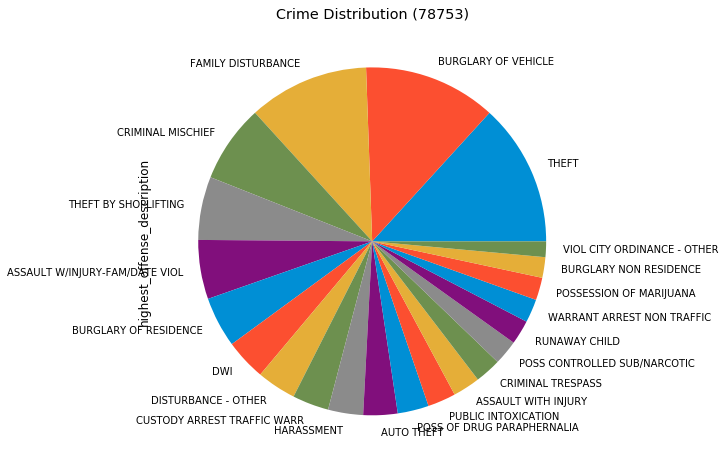

In [9]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages 
display(df_53_off)
print('----------------------------------')
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78753)')

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20019
BURGLARY OF VEHICLE               19658
THEFT                             15407
CRIMINAL MISCHIEF                 10901
ASSAULT W/INJURY-FAM/DATE VIOL     9553
BURGLARY OF RESIDENCE              8797
PUBLIC INTOXICATION                6357
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5611
HARASSMENT                         5428
DISTURBANCE - OTHER                5095
AUTO THEFT                         4495
ASSAULT WITH INJURY                4475
CRIMINAL TRESPASS                  3853
POSS CONTROLLED SUB/NARCOTIC       3817
POSSESSION OF MARIJUANA            3782
THEFT BY SHOPLIFTING               3550
POSS OF DRUG PARAPHERNALIA         3517
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2773
VIOL CITY ORDINANCE - OTHER        2195
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098030
BURGLARY OF VEHICLE               0.096263
THEFT                             0.075446
CRIMINAL MISCHIEF                 0.053381
ASSAULT W/INJURY-FAM/DATE VIOL    0.046780
BURGLARY OF RESIDENCE             0.043078
PUBLIC INTOXICATION               0.031129
CUSTODY ARREST TRAFFIC WARR       0.029435
DWI                               0.027476
HARASSMENT                        0.026580
DISTURBANCE - OTHER               0.024950
AUTO THEFT                        0.022011
ASSAULT WITH INJURY               0.021914
CRIMINAL TRESPASS                 0.018868
POSS CONTROLLED SUB/NARCOTIC      0.018691
POSSESSION OF MARIJUANA           0.018520
THEFT BY SHOPLIFTING              0.017384
POSS OF DRUG PARAPHERNALIA        0.017222
WARRANT ARREST NON TRAFFIC        0.016884
RUNAWAY CHILD                     0.013579
VIOL CITY ORDINANCE - OTHER       0.010749
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78741)')

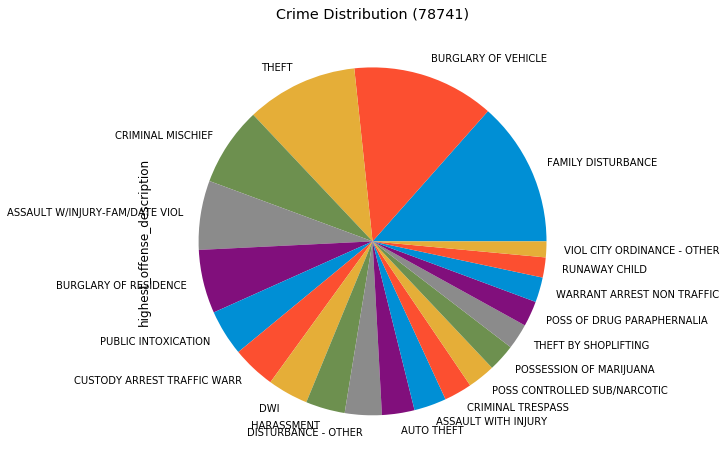

In [10]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages 
display(df_41_off)
print('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78741)')

<a id='q4'></a>
### D. Question 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

***The following line of code shows crime rates only >= 1% per zipcode.***

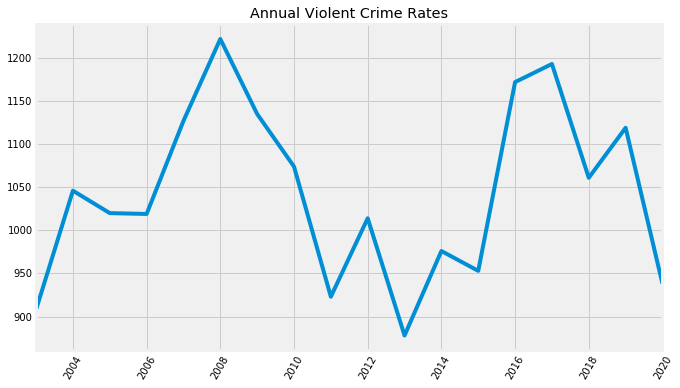

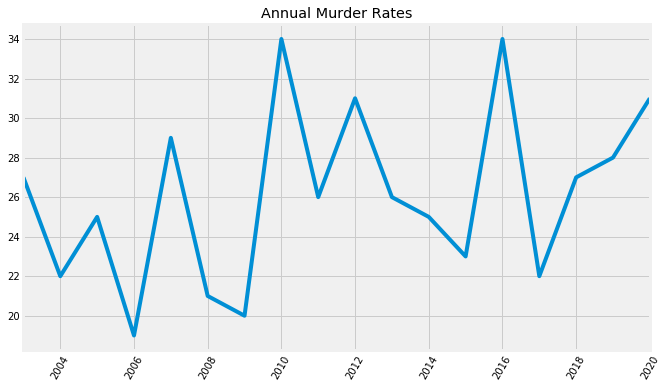

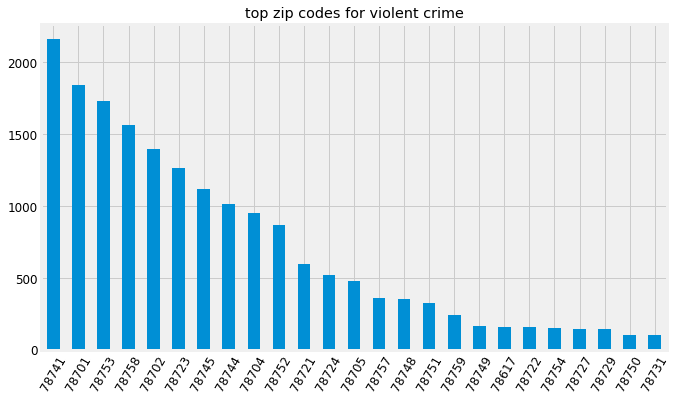

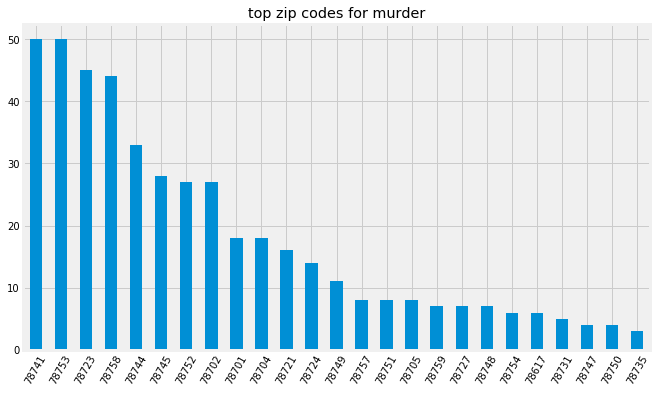

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78610,1,0,0,0
78613,14,0,1,6
78617,118,0,6,36
78621,1,0,0,0
78634,1,0,0,0
78652,2,0,0,0
78653,9,0,1,1
78660,64,0,2,17
78664,3,0,0,0


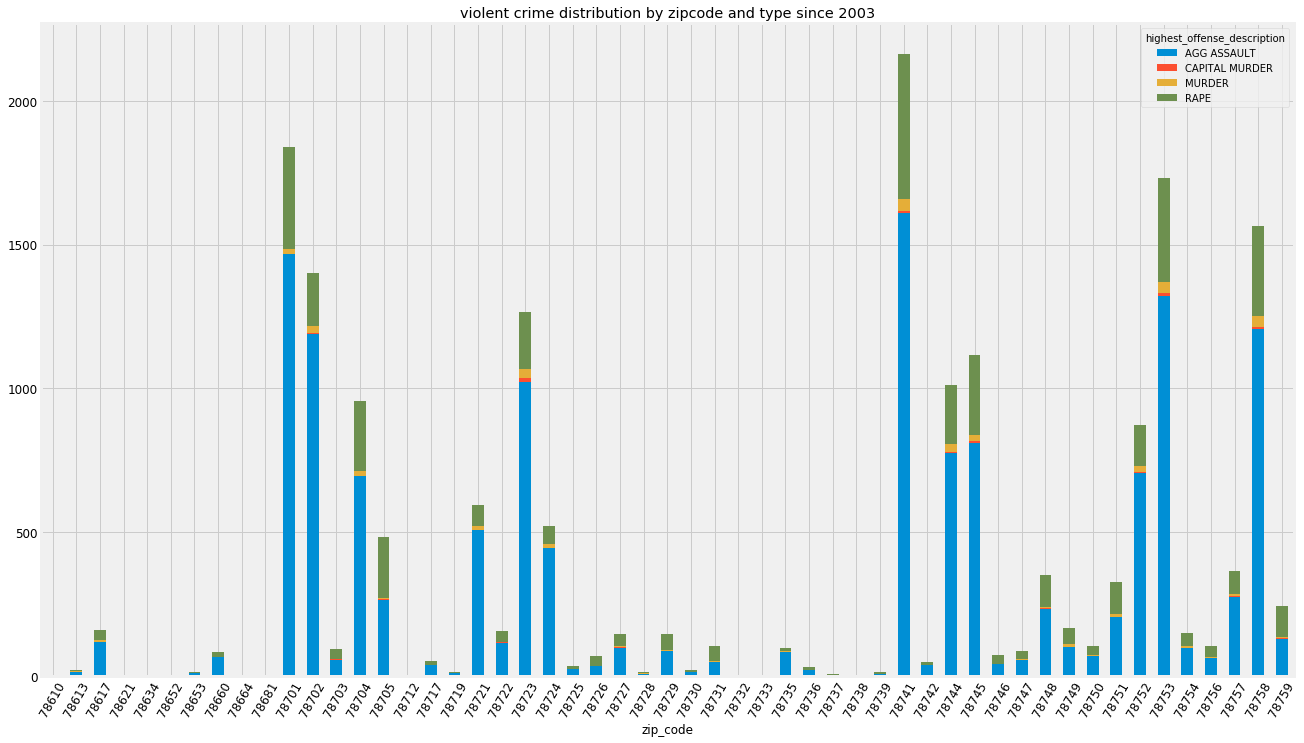

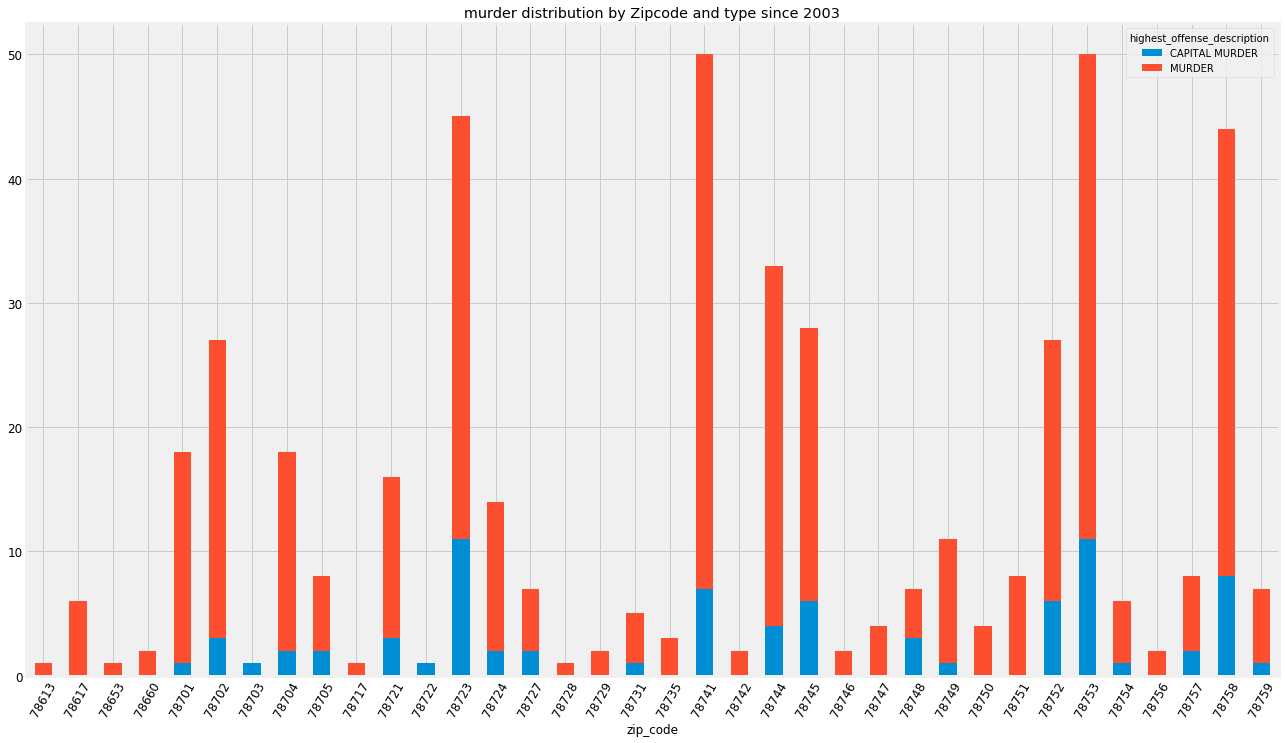

In [18]:
df_viol = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]') 
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == 'MURDER']
df_mur_cap = df[df.highest_offense_description == 'CAPITAL MURDER']
df_agg_asslt = df[df.highest_offense_description == 'AGG ASSAULT']
df_rape = df[df.highest_offense_description == 'RAPE']

viol_per_year = df_viol['year'].value_counts().sort_index()

viol_per_year.plot.line(rot=60,
                        title='Annual Violent Crime Rates', 
                        figsize=(10,6))
plt.show()

viol_mur_per_year = df_viol_mur['year'].value_counts().sort_index()

viol_mur_per_year.plot.line(rot=60, 
                            title='Annual Murder Rates', 
                            figsize=(10,6))
plt.show()

df_viol_zip = df_viol.zip_code.value_counts().head(25)

df_viol_zip.plot.bar(figsize=(10,6), 
                     title='top zip codes for violent crime', 
                     fontsize=12,  
                     rot=60)
plt.show()

df_viol_mur.zip_code.value_counts().head(25).plot.bar(title='top zip codes for murder', 
                                                      rot=60, 
                                                      figsize=(10,6))
plt.show()
        

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)

display(viol_freq)

viol_freq.plot.bar(figsize= figsize, 
                   title='violent crime distribution by zipcode and type since 2003', 
                   fontsize=12, 
                   stacked=True, 
                   rot=60)
plt.show()

viol_mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)

viol_mur_freq.plot.bar(figsize=figsize, 
                       title='murder distribution by Zipcode and type since 2003', 
                       fontsize=12, 
                       stacked=True,  
                       rot=60)
plt.show()

<a id='q5'></a>
### E. Question 5. What significance has the family violence factor played over time? 

0.058313184847156016

----------------------------------


occurred_date_time
2003    0.039437
2004    0.045315
2005    0.049476
2006    0.054267
2007    0.058797
2008    0.058310
2009    0.055014
2010    0.052704
2011    0.060332
2012    0.061667
2013    0.057990
2014    0.057629
2015    0.062594
2016    0.066157
2017    0.067817
2018    0.074285
2019    0.070213
2020    0.075345
Name: family_violence, dtype: float64

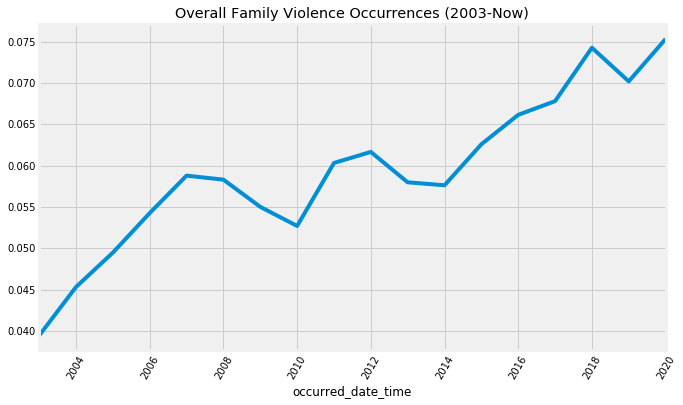

0.07817658962615827

----------------------------------


occurred_date_time
2003    0.035242
2004    0.036329
2005    0.048039
2006    0.043180
2007    0.056788
2008    0.069558
2009    0.066960
2010    0.062384
2011    0.079090
2012    0.082840
2013    0.109339
2014    0.123975
2015    0.129066
2016    0.100683
2017    0.097234
2018    0.113101
2019    0.080429
2020    0.076759
Name: family_violence, dtype: float64

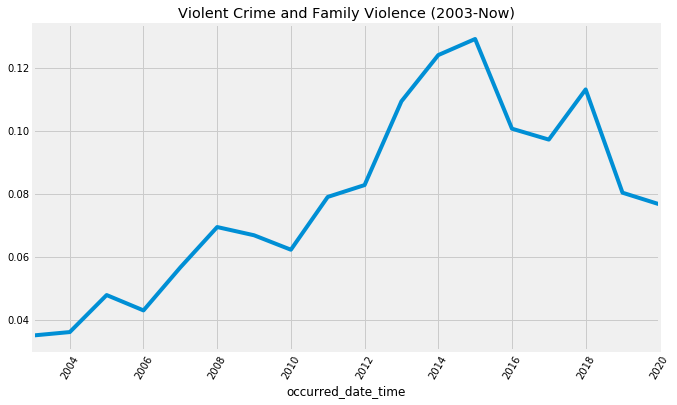

0.20638297872340425

----------------------------------


occurred_date_time
2003    0.148148
2004    0.090909
2005    0.320000
2006    0.105263
2007    0.068966
2008    0.238095
2009    0.050000
2010    0.264706
2011    0.230769
2012    0.225806
2013    0.307692
2014    0.240000
2015    0.304348
2016    0.117647
2017    0.181818
2018    0.222222
2019    0.321429
2020    0.225806
Name: family_violence, dtype: float64

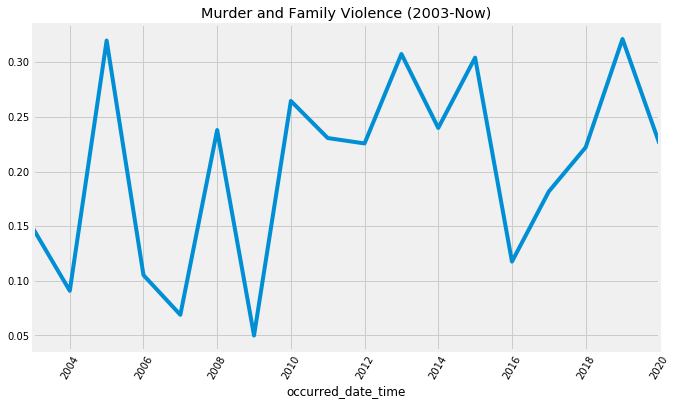

0.23038035628310063

----------------------------------


occurred_date_time
2003    0.154321
2004    0.083721
2005    0.105820
2006    0.126316
2007    0.169355
2008    0.194805
2009    0.205240
2010    0.169421
2011    0.265537
2012    0.271795
2013    0.279188
2014    0.281065
2015    0.294498
2016    0.330882
2017    0.293515
2018    0.257732
2019    0.256522
2020    0.301370
Name: family_violence, dtype: float64

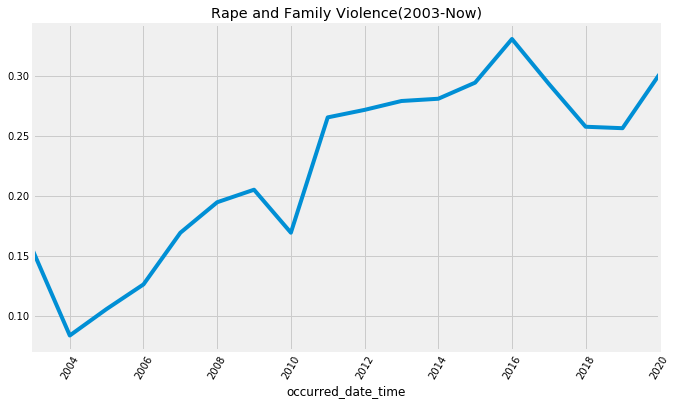

0.23038035628310063

----------------------------------


occurred_date_time
2003    0.004172
2004    0.022250
2005    0.026055
2006    0.022222
2007    0.023529
2008    0.036082
2009    0.031603
2010    0.021303
2011    0.027778
2012    0.030457
2013    0.050382
2014    0.032626
2015    0.040258
2016    0.027714
2017    0.029613
2018    0.052490
2019    0.025552
2020    0.027595
Name: family_violence, dtype: float64

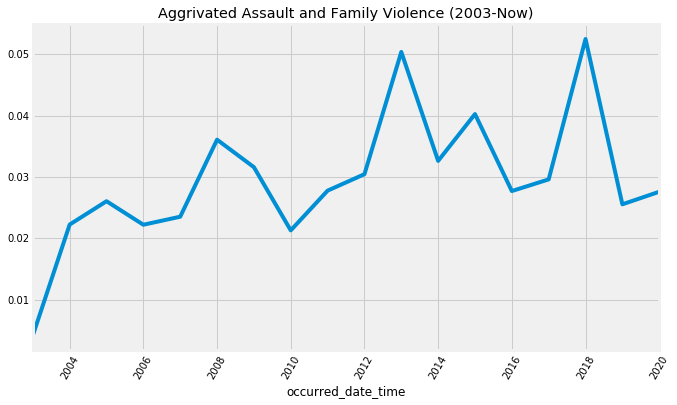

In [13]:
# Taking a look at first at the overall crime set
display(df.family_violence.mean())

print('----------------------------------')
display(df.groupby(df.index.year).family_violence.mean())

hrly_fam_viol_occurrences = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg.plot(rot=60, 
                  figsize=(10,6), 
                  title='Overall Family Violence Occurrences (2003-Now)')

plt.show()

# Now taking a look at violent crime specifically 
display(df_viol.family_violence.mean())

print('----------------------------------')
display(df_viol.groupby(df_viol.index.year).family_violence.mean())

viol_hrly_fam_viol_occurrences = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg.plot(rot=60, 
                       figsize=(10,6), 
                       title='Violent Crime and Family Violence (2003-Now)')

plt.show()

# Now taking a look at murder with the family violence factor included 
display(df_viol_mur.family_violence.mean())

print('----------------------------------')
display(df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean())

mur_hrly_fam_viol_occurrences = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg.plot(rot=60, 
                      figsize=(10,6), 
                      title='Murder and Family Violence (2003-Now)')

plt.show()

# Now taking a look at rape with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_rape.groupby(df_rape.index.year).family_violence.mean())

rape_hrly_fam_viol_occurrences = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg.plot(rot=60, 
                       figsize=(10,6), 
                       title='Rape and Family Violence(2003-Now)')

plt.show()

# Now taking a look at aggrivated assault with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean())

agg_asslt_fam_viol_avg = df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean()

agg_asslt_fam_viol_avg.plot(rot=60, 
                            figsize=(10,6), 
                            title='Aggrivated Assault and Family Violence (2003-Now)')

plt.show()

Overall, family violence is seeing an upward trend in overall crime. Violent crime has also seen an alarming upward trend of family violence. Rapes, for example, were part of incidents involving family violence a 3rd of the time in 2016 whereas in 2004, family violence was involved less than 1% of the time. 

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [45]:
df_viol_mur.dropna(subset=['latitude', 'longitude'], inplace=True)

In [55]:
# Making a folium map using the murder plots
m = folium.Map([30.2672, -97.7431], 
               tiles='Stamen Toner', 
               zoom_level=12)

for index, row in df_viol_mur.iterrows():
	lat = row['latitude']
	lon = row['longitude']
	name= row['incident_number']
	folium.Marker([lat, lon], popup=name).add_to(m)
    
m.save(outfile='aus_mur_map.html')

In [56]:
m

### G. Question 7. What caused crime to spike after 2018? 

What happened between 2018 and now? As indicated, crime rates began climbing upwards again in 2019 from a downward trend ever since 2008. Let's take a deeper look at that time line and see what's going on. 

## IV. Summary
Needless to say, violent crimes go hand-in-hand with other violent crimes.

So far, 78753 and 78741 are the top hotspots for all sorts of crime in Austin, including violent crime.

For non-capital murder, 78741 comes in at number 1 with 10.91%. 

#### ***It is important to note that murder does not necessarily make the defendant(s) automatically eligible for the death penalty. Under Texas law, we distinguish capital murder, through the motives and actions of the defendant(s) during the commission of a homicide, as whether or not automatically warranting an eventual date with the executioner. This includes such things as if the homicide was premeditated or not, if the defendant(s) murdered a police officer, etc.***

Regarding capital murder, 78723 comes in to share the number one spot with 78753, with a rate of 13.92% each. The 78741 area drops to the number 3 spot, carrying 8.97%. So, if we're honest, 78753 actually is the number 1 hotspot for murder because it has played host to 40 non-capital murders and 11 capital murders in total, meaning it has hosted 11% of all murders. 78741, if we combine all murders, only accounts for 10.56% of the total since 2003. 

Next, 78741 climbs back to claim the number 1 spot for rape at 12.09% -- 3.43 percentage points higher than the number 2 spot 78753 carrying 8.66% which is quite a significant lead when you look at it on the graph!! Why does rape occur so much more often in this area than in others?

A peculiar outlier is zipcode 78731. Although violent crime frequency ranks amongst the lowest there, rape accounts for over 50% of violent crimes committed in that area. Why is that? 

Astonishingly the family violence factor played an ever increasing role over over time, in regards to violent crime. From 2003 to 2015, family violence increased by nearly 10 percentage points--meaning you were likely to be the victim of a family member, during the commission of a rape, aggrivated assault, murder, or capital murder, only 3.15% of the time in 2003. But by 2015, that same likelihood rose to 12.82%!